In [1]:
# try random policy on the kitty
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio
import sys
from collections import defaultdict

import random
from datetime import datetime

# number of episodes 
n_epi = 200
alpha = 0.5
epsilon = 0.01

In [2]:
desc_file = open("map_14_14_v1.txt", "r") 
  
desc_content = desc_file.read() 

desc = desc_content.split("\n") 
desc = [d for d in desc if d!='']
desc_file.close() 
n_dim = len(desc[0])

# location of kitty, cat food, pet home, starting point, goal point
K_loc, C_loc, P_loc, S_loc, G_loc = list(), list(), list(), list(), list()

for i in range(len(desc)):
    if 'K' in desc[i]:
        K_loc.extend([i, desc[i].index('K')])
    if 'C' in desc[i]:
        C_loc.extend([i, desc[i].index('C')])
    if 'S' in desc[i]:
        S_loc.extend([i, desc[i].index('S')])
    if 'G' in desc[i]:
        G_loc.extend([i, desc[i].index('G')])

# kitty location is the same as pet home location initially
P_loc.extend([K_loc[0], K_loc[1]])
        

# locate holes 
H_loc_list = list()
for i in range(len(desc)):
    for d in range(len(desc[i])):
        if desc[i][d] == 'H':
            H_loc_list.append([i, d])

In [3]:
# remove S and G first and use P and C as starting point and goal to train kitty's Q-table
desc[S_loc[0]] = desc[S_loc[0]][:S_loc[1]]+'F'+desc[S_loc[0]][S_loc[1]+1:]
desc[G_loc[0]] = desc[G_loc[0]][:G_loc[1]]+'F'+desc[G_loc[0]][G_loc[1]+1:]
desc[P_loc[0]] = desc[P_loc[0]][:P_loc[1]]+'S'+desc[P_loc[0]][P_loc[1]+1:]
desc[C_loc[0]] = desc[C_loc[0]][:C_loc[1]]+'G'+desc[C_loc[0]][C_loc[1]+1:]

# env that the kitty heading for food
kitty_env_food = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')

In [4]:
def epsilon_greedy(env, epsilon, num_act, Q):
    """
    return a function to compute probability of choosing each action on the given state
    """
    def policy_s(state):
        action_probs = np.full(num_act,epsilon/num_act)
        a = np.argmax(Q[state])
        action_probs[a] += (1-epsilon)
        
        return action_probs
    return policy_s

def Q_learning_kitty(env, num_episodes = n_epi, discount_factor = 1.0, alpha = alpha, epsilon = epsilon):

    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # initialize Q-value
    # get num of actions
    nA = env.action_space.n
    policy = epsilon_greedy(env, epsilon, nA, Q)
    
    # to record for each record, how many iterations it takes to reach termination
    episode_iterations = np.zeros(num_episodes)
    # to record for each record, how much reward it got eventually
    episode_reward = np.zeros(num_episodes)
    
    for i_epi in range(num_episodes):

        if (i_epi+1) %100 == 0:
            print("\rEpisode: {}".format(i_epi+1), flush = True, end="")
        # initialize state    
        state = env.reset()[0]
        num_iter = 1
        
        while True:
            act_probs = policy(state)
            # randomly choose an action following probability in act_probs
            action = np.random.choice(len(act_probs), p = act_probs)
            next_state, reward, terminated, truncated, info = env.step(action)
            
            max_next_Q = max(Q[next_state])
            Q[state][action] += alpha *(reward + discount_factor * max_next_Q - Q[state][action])
            
            episode_iterations[i_epi] = num_iter+1
            episode_reward[i_epi] += reward
            
            if terminated:
                break
            
            state = next_state
            num_iter += 1
        
    return Q, episode_iterations, episode_reward
     
Q_kitty_food, episode_iterations_kitty_food, episode_reward_kitty_food = Q_learning_kitty(kitty_env_food)

Episode: 200

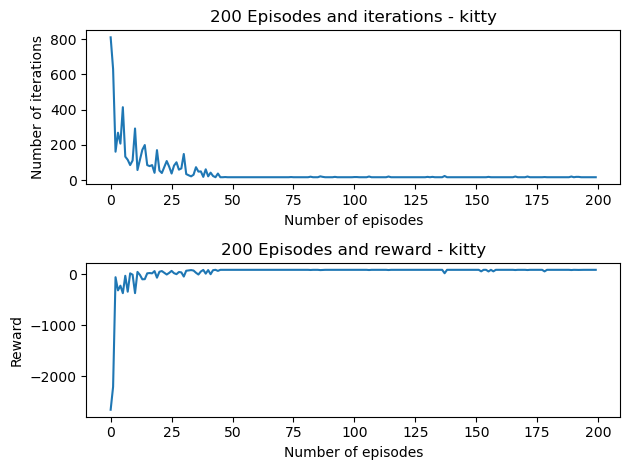

In [5]:
fig, axs = plt.subplots(2)
axs[0].set_title(f'{n_epi} Episodes and iterations - kitty')
axs[0].set_xlabel('Number of episodes')
axs[0].set_ylabel('Number of iterations')
axs[1].set_title(f'{n_epi} Episodes and reward - kitty')
axs[1].set_xlabel('Number of episodes')
axs[1].set_ylabel('Reward')
axs[0].plot(episode_iterations_kitty_food)
axs[1].plot(episode_reward_kitty_food)
fig.tight_layout()

plt.savefig(f'Plot/{n_dim}x{n_dim}_{n_epi} Episodes and iterations - kitty_once_method_1.png', bbox_inches='tight')


In [6]:
kitty_info = {
    'k': K_loc,
    'home': P_loc, 
    # if kitty is seeking food or home. True for food
    'if_food' : True,
    'food' : C_loc,
    'holes' : H_loc_list,
    'start' : S_loc,
    'goal' : G_loc,
    }

def kitty_move(env, kitty, num_dim, Q_k_food):
    # if kitty already arrives at food, no need to move kitty
    if kitty['k'] != kitty['food']:
    # revert the component of kitty's current location
        env, kitty = to_original_component(env, kitty)
        # compute kitty's state
        k_state = kitty['k'][0] * n_dim + kitty['k'][1] 

        # get kitty's action
        k_act = np.argmax(Q_k_food[k_state])

        if k_act == 0: # LEFT
            kitty['k'][1] = max(kitty['k'][1]-1, 0)
        elif k_act ==1: # DOWN
            kitty['k'][0] = min(kitty['k'][0]+1, num_dim -1)
        elif k_act == 2: # RIGHT
            kitty['k'][1] = min(kitty['k'][1]+1, num_dim -1)
        elif k_act ==3: # UP
            kitty['k'][0] = max(kitty['k'][0]-1, 0)

        env.desc[kitty['k'][0], kitty['k'][1]] = b'K'
    
    return env, kitty


def to_original_component(env, kitty):
    # change kitty's current location to the original component
    if kitty['k'] in kitty['holes']:
        env.desc[kitty['k'][0], kitty['k'][1]] = b'H'
    elif kitty['k'] == kitty['start']:
        env.desc[kitty['k'][0], kitty['k'][1]] = b'S'
    elif kitty['k'] == kitty['goal']:
        env.desc[kitty['k'][0], kitty['k'][1]] = b'G'
    elif kitty['k'] == kitty['home']:    
        env.desc[kitty['k'][0], kitty['k'][1]] = b'P'
    else:
        env.desc[kitty['k'][0], kitty['k'][1]] = b'F'
        
    return env, kitty



In [7]:
# put S, G, K, C back to train elf's Q-table when elf is heading to goal
# pet home is coverred by kitty initially
desc[S_loc[0]] = desc[S_loc[0]][:S_loc[1]]+'S'+desc[S_loc[0]][S_loc[1]+1:]
desc[G_loc[0]] = desc[G_loc[0]][:G_loc[1]]+'G'+desc[G_loc[0]][G_loc[1]+1:]
desc[P_loc[0]] = desc[P_loc[0]][:P_loc[1]]+'K'+desc[P_loc[0]][P_loc[1]+1:]
desc[C_loc[0]] = desc[C_loc[0]][:C_loc[1]]+'C'+desc[C_loc[0]][C_loc[1]+1:]

# env where the elf is heading for goal
env_g = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')



def Q_learning(env, kitty, num_episodes = n_epi, Q_k_food = Q_kitty_food, num_dim = n_dim, \
               discount_factor = 1.0, alpha = alpha, epsilon = epsilon):
    


    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # initialize Q-value
    # get num of actions
    nA = env.action_space.n
    policy = epsilon_greedy(env, epsilon, nA, Q)
    
    # to record for each record, how many iterations it takes to reach termination
    episode_iterations = np.zeros(num_episodes)
    # to record for each record, how much reward it got eventually
    episode_reward = np.zeros(num_episodes)
    
    for i_epi in range(num_episodes):

        if (i_epi+1) %100 == 0:
            print("\rEpisode: {}".format(i_epi+1), flush = True, end="")
        # initialize elf's state    
        state = env.reset()[0]
        
        # convert current location of kitty to its original component
        env, kitty = to_original_component(env, kitty)
        
        # reset kitty's location to kitty's home for each episode
        kitty['k'][0], kitty['k'][1] = kitty['home'][0], kitty['home'][1]  
        env.desc[kitty['k'][0], kitty['k'][1]] = b'K'
        env.desc[kitty['food'][0], kitty['food'][1]] = b'C'
        
        num_iter = 1

        
        while True:
            # choose kitty's action based on kitty's Q table first
            env, kitty = kitty_move(env, kitty, num_dim, Q_k_food)
            
            act_probs = policy(state)
            # randomly choose an action following probability in act_probs
            action = np.random.choice(len(act_probs), p = act_probs)
            next_state, reward, terminated, truncated, info = env.step(action)
            
            max_next_Q = max(Q[next_state])
            Q[state][action] += alpha *(reward + discount_factor * max_next_Q - Q[state][action])
            
            episode_iterations[i_epi] = num_iter+1
            episode_reward[i_epi] += reward
            
            if terminated:
                break
            
            state = next_state
            num_iter += 1
            
        
    return Q, episode_iterations, episode_reward



Q_g, episode_iterations_g, episode_reward_g = Q_learning(env_g, kitty=kitty_info)

Episode: 200

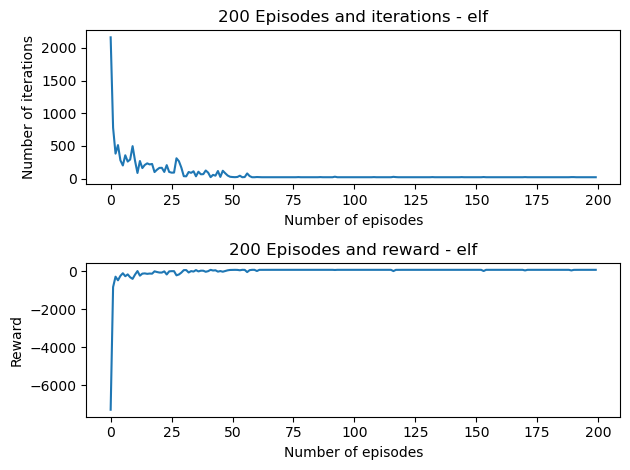

In [8]:
fig, axs = plt.subplots(2)
axs[0].set_title(f'{n_epi} Episodes and iterations - elf')
axs[0].set_xlabel('Number of episodes')
axs[0].set_ylabel('Number of iterations')
axs[1].set_title(f'{n_epi} Episodes and reward - elf')
axs[1].set_xlabel('Number of episodes')
axs[1].set_ylabel('Reward')
axs[0].plot(episode_iterations_g)
axs[1].plot(episode_reward_g)
fig.tight_layout()
plt.savefig(f'Plot/{n_dim}x{n_dim}_{n_epi} Episodes and iterations - elf_once_method_1.png', bbox_inches='tight')


In [9]:

# Reverse S, G back to build testing env
desc[S_loc[0]] = desc[S_loc[0]][:S_loc[1]]+'S'+desc[S_loc[0]][S_loc[1]+1:]
desc[G_loc[0]] = desc[G_loc[0]][:G_loc[1]]+'G'+desc[G_loc[0]][G_loc[1]+1:]

env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')

# calculate state of S and G
S_state = S_loc[0] * n_dim + S_loc[1]
G_state = G_loc[0] * n_dim + G_loc[1]


# datetime object containing current date and time
now = datetime.now().strftime("%d-%m-%Y %H_%M_%S")
file_name = f"Demo/epi_{n_epi}/kitty_qlearning-{n_dim}x{n_dim}map_once_{n_epi}_episodes_{now}.gif"


def Demo_GIF(kitty, env = env, Q_k_food = Q_kitty_food, \
                     Q_g = Q_g, num_dim = n_dim, address = file_name, \
                     S_state = S_state, G_state = G_state):
    
    pics = []
    # starting at elf heading for goal
    state = env.reset()[0]
    
    env, kitty = to_original_component(env, kitty)
        
    # reset kitty's location 
    kitty['k'][0], kitty['k'][1] = kitty['home'][0], kitty['home'][1]  
    env.desc[kitty['k'][0], kitty['k'][1]] = b'K'
    env.desc[kitty['food'][0], kitty['food'][1]] = b'C'
    
    
    num_collision = 0
    
    while True:
        pics.append(env.render())
        
        # choose kitty's action based on kitty's Q table first
        env, kitty = kitty_move(env, kitty, num_dim, Q_k_food)
            
        # choose elf's action based on Q-table when heading to goal
        action = np.argmax(Q_g[state]) 

        next_state, reward, terminated, truncated, info = env.step(action)

        if terminated:
            # reverse direction
            break
    
        state = next_state
        k_state = kitty['k'][0] * num_dim + kitty['k'][1]
        if k_state == state:
            num_collision += 1
    
    print(f'Number of collisions when episode number is {n_epi}:', num_collision)
    print(f'Demo GIF is: {file_name}')

    pics.append(env.render())
    env.close()

    imageio.mimsave(address, pics)
    


In [10]:
%%time
Demo_GIF(kitty_info)


Number of collisions when episode number is 200: 0
Demo GIF is: Demo/epi_200/kitty_qlearning-14x14map_once_200_episodes_26-05-2024 17_50_12.gif
CPU times: user 807 ms, sys: 93.3 ms, total: 900 ms
Wall time: 1.18 s
